In [1]:
import pandas as pd
from sklearn import set_config
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
set_config(transform_output = "pandas")

import tensorflow as tf

In [2]:
# Load wildfire and non-wildfire datasets
main_df = pd.read_csv("downsampled_df.csv",index_col=0)

# Remove the first unnamed column
wf_df=main_df[main_df['fire']==1]
nwf_df=main_df[main_df['fire']==0]

# Define Split ratio, aka percentage of the combined data goes to training
split=[0.6,0.2,0.2]
wf_sort = wf_df.sort_values(by='date')
nwf_sort = nwf_df.sort_values(by='date')


for i in [0,1,2]:
    wf_memory=0
    nfw_memory=0
    wf_selected=[]
    nwf_selected=[]
    wf_size = int(split[i] * len(wf_df))
    nwf_size = int(split[i] * len(nwf_df))
    if i==0:
        wf_selected=wf_sort[:wf_size]
        nwf_selected=nwf_sort[:nwf_size]
        wf_memory=wf_size
        nwf_memory=nwf_size
        train_data = pd.concat([wf_selected, nwf_selected])
    if i==1:
        wf_selected=wf_sort[wf_memory:wf_memory+wf_size]
        nwf_selected=nwf_sort[nwf_memory:nwf_memory+nwf_size]
        wf_memory=wf_size
        nwf_memory=nwf_size
        test_data = pd.concat([wf_selected, nwf_selected])
    if i==2:
        wf_selected=wf_sort[wf_memory:]
        nwf_selected=nwf_sort[nwf_memory:]
        val_data = pd.concat([wf_selected, nwf_selected])                

X_train = train_data.drop(columns={'fire','date'})
X_test = test_data.drop(columns={'fire','date'})
X_val = val_data.drop(columns={'fire','date'})
y_train = train_data['fire']
y_test = test_data['fire']
y_val = val_data['fire']


In [3]:
# Load the model
model = tf.keras.models.load_model('ANN_selected parameters_RX.h5')

# Verify the model's architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 204)            │         3,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           205 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,879 (15.16 KB)

 Trainable params: 3,877 (15.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [4]:
# Manual separate numerical and categorical columns
pass_features = [ 'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation', 'slope_of_sub_gridscale_orography']
categorical_features = ['type_of_high_vegetation', 'type_of_low_vegetation']
numeric_features = train_data.drop(columns=pass_features).drop(columns=categorical_features).keys().drop(['fire','date'])
#numeric_features = numeric_features.insert(-1,'distance_to_road') Resevered for future development
feature_names =['numeric__fire_count_past_30Days','numeric__DMC','numeric__global_noon_LST_2m_temperature','numeric__BUI',
                'numeric__FWI','numeric__latitude','numeric__FFMC','numeric__global_noon_LST_relative_humidity','numeric__24hr_max_temperature',
                'numeric__global_noon_LST_2m_temperature_1dayLag','pass__leaf_area_index_high_vegetation','numeric__global_noon_LST_2m_temperature_2dayLag',
                'numeric__high_vegetation_cover','numeric__24hr_max_temperature_1dayLag','numeric__low_vegetation_cover','pass__leaf_area_index_low_vegetation',
                'numeric__24hr_accumulated_precipitation']

# Define numeric and categorical transformer below
scale=ColumnTransformer([('scale_transformer',StandardScaler(),numeric_features)],verbose_feature_names_out=False).set_output(transform='pandas')

cate=ColumnTransformer([('categorical_transformer',OneHotEncoder(sparse_output=False),categorical_features)],verbose_feature_names_out=False).set_output(transform='pandas')

pss=ColumnTransformer([('Pass_transformer','passthrough',pass_features)],verbose_feature_names_out=False).set_output(transform='pandas')
Drop_transformer=ColumnTransformer([('Drop_transformer','passthrough',feature_names)],verbose_feature_names_out=False).set_output(transform='pandas')

Data_pipeline = Pipeline(steps=[
    ('Feature Union',FeatureUnion([('numeric', scale),('categorical',cate),('pass',pss)])),
    ('Drop Columns',Drop_transformer)]
    )

Process Data and analyze

662/662 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
Threshold for fpr 0.4 = 0.23780012130737305


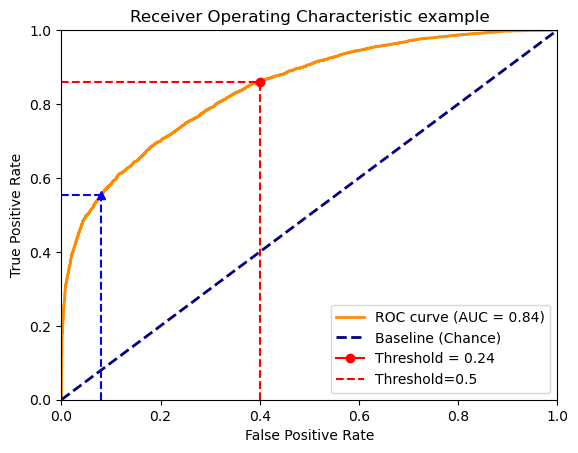

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc


X_train_processed = Data_pipeline.fit_transform(X_train)
X_test_processed = Data_pipeline.transform(X_test)
X_val_processed = Data_pipeline.transform(X_val)


# Predict probabilities for the positive class
y_score = model.predict(X_test_processed)  # Modify if necessary to suit your model's output shape

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Find the threshold closest to an FPR of 0.4
target_fpr = 0.4
closest_index_fpr = np.argmin(np.abs(fpr - target_fpr))
closest_fpr = fpr[closest_index_fpr]
closest_tpr = tpr[closest_index_fpr]
closest_threshold_fpr = thresholds[closest_index_fpr]
print(f'Threshold for fpr 0.4 = {closest_threshold_fpr}')

# Find the point where the threshold is closest to 0.5
target_threshold = 0.5
closest_index_threshold = np.argmin(np.abs(thresholds - target_threshold))
threshold_fpr = fpr[closest_index_threshold]
threshold_tpr = tpr[closest_index_threshold]
closest_threshold = thresholds[closest_index_threshold]

# Plotting the ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# Plot point and line for FPR=0.4
plt.plot(closest_fpr, closest_tpr, marker='o', color='red')
plt.plot([closest_fpr, closest_fpr], [0, closest_tpr], color='red', linestyle='--')
plt.plot([0, closest_fpr], [closest_tpr, closest_tpr], color='red', linestyle='--')
# Plot point and line for threshold=0.5
plt.plot(threshold_fpr, threshold_tpr, marker='^', color='blue')
plt.plot([threshold_fpr, threshold_fpr], [0, threshold_tpr], color='blue', linestyle='--')
plt.plot([0, threshold_fpr], [threshold_tpr, threshold_tpr], color='blue', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic example')
plt.legend([
    'ROC curve (AUC = {:.2f})'.format(roc_auc),
    'Baseline (Chance)',
    'Threshold = {:.2f}'.format(closest_threshold_fpr),
    'Threshold=0.5'
], loc="lower right")
plt.show()

In [6]:
def threshold_predict(model,X,threshold):
    return (model.predict(X) > threshold).astype(int)

def add_back_original_features(X_processed,df_original):
    return pd.merge(X_processed, df_original, left_index=True, right_index=True, how='left')

In [13]:
# Visualize predictions on validation set
from sklearn.metrics import accuracy_score, f1_score


threshold = 0.5 # 0.23780012130737305
y_predict = threshold_predict(model,X_val_processed,threshold)
y_true = y_val

# Evaluate the accuracy of the model on the validation set
accuracy = accuracy_score(y_true, y_predict)
print("Validation set accuracy:", accuracy)
print('f1 score: ',f1_score(y_true, y_predict))

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 2s 538us/step
Validation set accuracy: 0.6956435599973584
f1 score:  0.6530315197751455


Plot the predictions over time

In [9]:
import os

from sklearn.metrics import confusion_matrix
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader


def prepare_df_for_plotting(X,y_pred,df):
    """
    X is the test inputs, y_pred is the resulting model predictions
    df is the original dataframe to add back date, latitude, and longitude columns
    """
    df = add_back_original_features(X,df)
    df['prediction'] = y_pred
    # Classify each prediction
    df['result'] = 'TN'
    df.loc[(df['fire'] == 1) & (df['prediction'] == 1), 'result'] = 'TP'
    df.loc[(df['fire'] == 0) & (df['prediction'] == 1), 'result'] = 'FP'
    df.loc[(df['fire'] == 1) & (df['prediction'] == 0), 'result'] = 'FN'

    return df

def plot_daily_predictions(df,save_dir):
    # Define the geographic bounds of Alberta
    extent = [-120, -110, 49, 60]  # [west, east, south, north]
    provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none',
            edgecolor='black'
        )

    for date in df['date'].unique():
        df_date = df[df['date'] == date]

        fig = plt.figure(figsize=(10, 10))
        # Define the projection and extent
        ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-115, central_latitude=55))
        ax.set_extent(extent)
        
        # Add geographic features
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.LAKES, alpha=0.5)
        ax.add_feature(provinces, linestyle='-', edgecolor='black')

        # Plot points for the given date
        categories = ['TP', 'TN', 'FP', 'FN']
        colors = ['green', 'blue', 'red', 'yellow']
        for category, color in zip(categories, colors):
            df_cat = df_date[df_date['result'] == category]
            plt.scatter(df_cat['longitude'], df_cat['latitude'], c=color, label=category, alpha=0.6, transform=ccrs.PlateCarree())
        
        plt.title(f'Fire Prediction Results for {date}')
        plt.legend(loc='lower left')
        
        # Save the plot
        plt.savefig(os.path.join(save_dir, f'{date}_predictions.png'))
        plt.close(fig)

def plot_incorrect_predictions(df, save_path):
    # Filter to include only incorrect predictions
    incorrect_df = df[(df['result'] == 'FP') | (df['result'] == 'FN')]

    # Group by latitude and longitude, count occurrences
    agg_df = incorrect_df.groupby(['latitude', 'longitude']).size().reset_index(name='counts')

    fig = plt.figure(figsize=(40, 40))
    ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-115, central_latitude=55))

    # Set the geographic bounds to focus on Alberta
    extent = [-120, -110, 49, 60]  # Adjust as necessary
    ax.set_extent(extent)
    
    # Add provincial borders and other geographic features
    provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none',
            edgecolor='black'
        )
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(provinces, linestyle='-', edgecolor='black')

    # Normalize the counts to map colors
    norm = plt.Normalize(vmin=agg_df['counts'].min(), vmax=agg_df['counts'].max())

    # Plot each point, coloring based on the number of incorrect predictions
    scatter = ax.scatter(agg_df['longitude'], agg_df['latitude'], 
                        c=agg_df['counts'], cmap='Reds', norm=norm, 
                        edgecolor='k', linewidth=0.5, alpha=0.7, s=600, # Adjust size with `s`
                        transform=ccrs.PlateCarree())

    # Add text for the number of incorrect predictions at each point
    for _, row in agg_df.iterrows():
        ax.text(row['longitude'], row['latitude'], str(int(row['counts'])), 
                transform=ccrs.PlateCarree(),
                ha='center', va='center', fontsize=12, color='black')  # Adjusted alignment and color

    # Add a colorbar
    cbar = plt.colorbar(scatter, shrink=0.5, aspect=5)
    cbar.set_label('Number of Incorrect Predictions',fontsize=40)
    cbar.ax.tick_params(labelsize=30)

    plt.title('Incorrect Predictions Across Alberta',fontsize=40)
    plt.savefig(save_path)
    plt.close(fig)

Text(0.5, 23.52222222222222, 'Predicted Label')

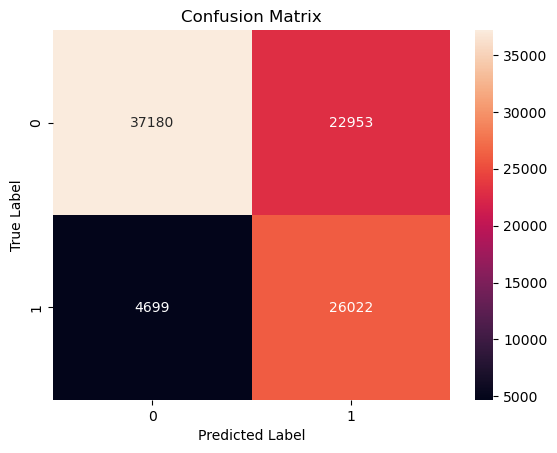

In [14]:
cm = confusion_matrix(y_true,y_predict)
sns.heatmap(cm,annot=True,fmt='.6g')
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

In [17]:
df = prepare_df_for_plotting(X_val_processed,y_predict,main_df)

In [18]:
plot_incorrect_predictions(df,'all_incorrect_predictions.png')

In [ ]:
plot_daily_predictions(df,'model_predictions/')